In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj
import sys
from joblib import Parallel, delayed
from tqdm import tqdm

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm_ac import Boxm
import pycontrails.models.boxmodel.boxm_script as boxm_script

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 235.0,  # K
    "specific_humidity": 0.003,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-01-20 13:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=60),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 0.0,  # deg
    "fl0_coords0": (0.1, 0.125, 12500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 1,  # number of aircraft
}

In [4]:
 # plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=2),  # integration time step
    "max_age": pd.Timedelta(hours=2),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 50.0,  # initial plume width, [m]
    "shear": 0.01,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-01-20 12:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(hours=3),  # chemistry runtime
    "ts_chem": pd.Timedelta(seconds=20),  # chemistry time step
    "lat_bounds": (0.0, 1.0),  # lat bounds [deg]
    "lon_bounds": (0.0, 1.0),  # lon bounds [deg]
    "alt_bounds": (12000, 13000),  # alt bounds [m]
    "hres_pl": 0.05,  # horizontal resolution of the plume, [deg]
    "hres_chem": 0.05,  # horizontal resolution [deg]
    "vres_chem": 500,  # vertical resolution [m]
}

In [6]:
lats_pl = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_pl"], chem_params["hres_pl"]
)

lons_pl = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_pl"], chem_params["hres_pl"]
)

In [7]:
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1] + chem_params["vres_chem"], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)

In [8]:
fl_df, pl_df, boxm = boxm_script.boxm_run(lons, lons_pl, lats, lats_pl, alts, times, fl_params, plume_params, chem_params, met_params)

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i].dataframe[column] = flights[i].dataframe[column].fillna(method='ffill')


Processing time:  2022-01-20 13:02:00


/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:196: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i][column] = flights[i][column].fillna(method='ffill')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Processing time:  2022-01-20 13:04:00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:06:00


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:08:00


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:12:00


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:14:00


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:16:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:18:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:20:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:22:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:24:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:26:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:28:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:30:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:32:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:34:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:36:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:38:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:40:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:42:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:44:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:46:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:48:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:50:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:52:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:54:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:56:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 13:58:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:02:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:04:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:06:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:08:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:10:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:12:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:14:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:16:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:18:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:20:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:22:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:24:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:26:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:28:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:30:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:32:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:34:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:36:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:38:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:40:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:42:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:44:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:46:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:48:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:50:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:52:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:54:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:56:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 14:58:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-01-20 15:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm_ac.py:174: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.boxm_ds["J"] = (["time", "level", "longitude", "latitude", "photol_params"], da.zeros((self.boxm_ds.dims["time"], self.boxm_ds.dims["level"], self.boxm_ds.dims["longitude"], self.boxm_ds.dims["latitude"], 5)))
/home/ktait98/pycontrails_kt/pycontrails/models/boxmodel/boxm_ac.py:176: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consis

MultiIndex([(165.10085173011288, 0.0,                 0.0),
            (165.10085173011288, 0.0,                0.05),
            (165.10085173011288, 0.0,                 0.1),
            (165.10085173011288, 0.0, 0.15000000000000002),
            (165.10085173011288, 0.0,                 0.2),
            (165.10085173011288, 0.0,                0.25),
            (165.10085173011288, 0.0, 0.30000000000000004),
            (165.10085173011288, 0.0, 0.35000000000000003),
            (165.10085173011288, 0.0,                 0.4),
            (165.10085173011288, 0.0,                0.45),
            ...
            (193.30062328740988, 1.0,                0.55),
            (193.30062328740988, 1.0,  0.6000000000000001),
            (193.30062328740988, 1.0,                0.65),
            (193.30062328740988, 1.0,  0.7000000000000001),
            (193.30062328740988, 1.0,                0.75),
            (193.30062328740988, 1.0,                 0.8),
            (193.3006232

In [9]:
# ts = 6

# fl_df.loc[fl_df["time"] == fl_df["time"][ts]]
# pl_df.loc[pl_df["time"] == fl_df["time"][ts]]

#pl_df

boxm.boxm_ds_unstacked.emi.sel(emi_species="NO", time=fl_df.time[2]).sel(level=178.6, method="nearest")

<xarray.DataArray 'emi' (longitude: 21, latitude: 21)> Size: 4kB
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
...
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])
Coordinates:
    level         float64 8B 178.6
  * longitude     (longitude) float64 168B 0.0 0.05 0.1 0.15 ... 0.9 0.95 1.0
  * latitude      (latitude) float64 168B 0.0 0.05 0.1 0.15 ... 0.9 0.95 1.0
    time          datetime64[ns] 8B 2022-01-20T13:04:00
    air_pressure  (longitude, latitude) float64 4kB 1.786e+04 ... 1.786e+04
    altitude      (longitude, latitude) float64 4kB 1.25e+04 ... 1.25e+04
    emi_species   <U7 28B 'NO'

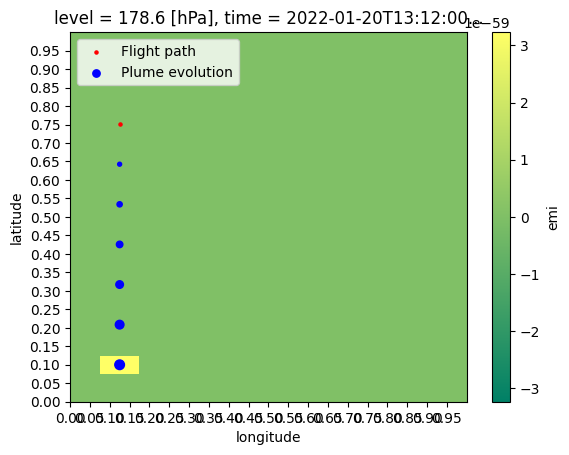

In [10]:
fig1, ax1 = plt.subplots()
ax1.set_xticks(np.arange(chem_params["lon_bounds"][0], chem_params["lon_bounds"][1], 0.05))
ax1.set_yticks(np.arange(chem_params["lat_bounds"][0], chem_params["lat_bounds"][1], 0.05))


ts = 6

# Plot the heatmap
heatmap_data = boxm.boxm_ds_unstacked.emi.sel(emi_species="NO", time=fl_df.time[ts]).sel(level=178.6, method="nearest").transpose("latitude", "longitude")
heatmap_data.plot(ax=ax1, cmap='summer')  # You can choose a colormap of your preference


scat_fl = ax1.scatter(fl_df["longitude"].loc[fl_df["time"] == fl_df["time"][ts]],
                      fl_df["latitude"].loc[fl_df["time"] == fl_df["time"][ts]], 
                      s=5, c="red", label="Flight path")

scat_pl = ax1.scatter(pl_df["longitude"].loc[pl_df["time"] == fl_df["time"][ts]],
                      pl_df["latitude"].loc[pl_df["time"] == fl_df["time"][ts]],
                      s=10E-2 * pl_df["width"].loc[pl_df["time"] == fl_df["time"][ts]], c="blue", label="Plume evolution")

ax1.legend(loc="upper left")
ax1.set_xlim([chem_params["lon_bounds"][0], chem_params["lon_bounds"][1]])
ax1.set_ylim([chem_params["lat_bounds"][0], chem_params["lat_bounds"][1]])
#plt.grid()
plt.show()

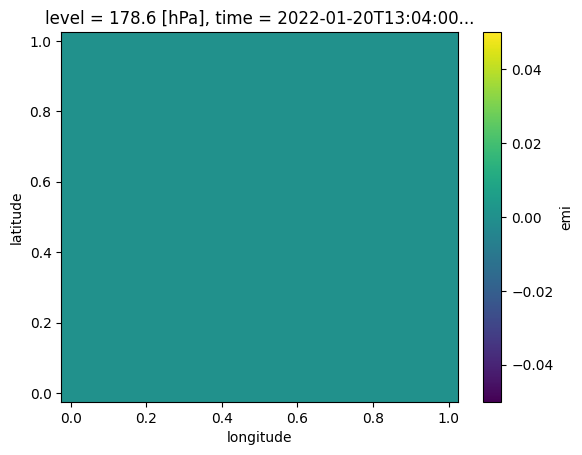

In [11]:
boxm.boxm_ds_unstacked.emi.sel(emi_species="NO", time=fl_df.time[2]).sel(level=178.6, method="nearest").transpose("latitude", "longitude").plot()

In [12]:
boxm.mc_test(fl_df)

1.1184740279383707 0.0
2.2369480558767414 0.0
3.355422083815113 0.0
4.473896111753484 6.374299389640777e-284
5.592370139691854 3.4844401427036645e-150
6.710844167630225 8.979611905643277e-90
7.829318195568596 2.7415880632526984e-58


In [13]:
# # Select the DataArray for the specified emi_species
# grid_mass = boxm.boxm_ds_unstacked.emi.sel(emi_species="NO", time="2022-01-20T13:030:00.000000000").sel(level=178.6, method="nearest") #.transpose("latitude", "longitude").plot()

# grid_mass_over_zero = grid_mass.where(grid_mass > 0, drop=True)
# grid_mass_over_zero



In [14]:
# plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# boxm.boxm_ds["M"].sel(cell=14).plot()
# #boxm.boxm_ds["Y_orig"].sel(species="NO").plot()
# plt.legend()
# plt.show()
#fl_gen.anim_fl(fl_df, pl_df)

In [15]:
# boxm.anim_chem("emi", "NO", 178.6)